# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime
from collections import defaultdict
import pickle
import pandas as pd
import numpy as np
import scipy as sp

from creon.loadcreon import LoadCreon, save_search, load_search
from creon.creonsklearn.creonmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer, pu_mix_assumed_f1beta10_scorer
from creon.semisuperhelper import SemiSupervisedHelper
from creon.creonsklearn.pnuwrapper import PNUWrapper
from creon.creonsklearn.jeffsearchcv import JeffRandomSearchCV, extract_score_grid
from creon.creonsklearn.nestedcross import NestedCV
from creon.creonsklearn.frankenscorer import FrankenScorer, extract_scores_from_nested
from creon.creonsklearn.repeatedsampling import RepeatedRandomSubSampler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.externals.joblib import Parallel, delayed

from lime.lime_tabular import LimeTabularExplainer

In [4]:
from creon.modeldeepdive import ModelDeepDive, create_model_6

# Load and then Train Model 6

In [5]:
path = "C:\Data\\010317\membership14_final_0103.txt"
print("Loading {}".format(path))
try:
    lc = LoadCreon(path)
except FileNotFoundError:
    #This is for running on a machine not on network that can see the data
    print("File doesn't exist, generating fake data!")
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=10000, n_features=200, n_informative=50, n_redundant=100, n_classes=2,
                               n_clusters_per_class=3, weights=[0.9], flip_y=0, hypercube=False,
                               random_state=101)

    #make this like the unlabeled problem we are solving -change most to unlabeled class == -1
    rnd_unlabeled = np.random.choice([True, False], size=len(y), replace=True, p=[0.8,0.2])
    y[rnd_unlabeled] = -1
    X = pd.DataFrame(X)
    y = pd.Series(y)
else:
    X = lc.X
    y = lc.y
print("Done loading")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=771, stratify=y)
print("Split Data: train_size {}, test_size {}".format(X_train.shape, X_test.shape))

Loading C:\Data\010317\membership14_final_0103.txt
Done loading
Split Data: train_size (352556, 287), test_size (88140, 287)


In [7]:
print("Create and train model")
model6 = create_model_6(X_train, y_train)
print("Done with model {}".format(model6))
scores, _ = FrankenScorer()(model6, X_test.values, y_test.values)
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values,
                                 feature_selection='lasso_path', class_names=['No EPI','EPI'],
                                 discretize_continuous=True)

Create and train model
generating 93 samples of indices to use to train multiple estimators, sized 5459 elements with last being 3106 elements


[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:  2.6min finished


Done with model PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features=87, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=0.01, min_weight...      random_state=83, sample_imbalance=0.4406340820472374,
             verbose=1, voting='thresh'),
      num_unlabeled=1.0, pu_learning=True, random_state=1,
      threshold_set_pct=None)


[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.3s finished
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.4s finished
C:\Users\jeffrey.gomberg\AppData\Local\Continuum\Anaconda3\envs\creon\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [8]:
scores

{'SCORE': 0.85387547649301154,
 'assumed_brier': 0.047231727428331254,
 'assumed_brier_neg': 0.046789270426547652,
 'assumed_f1': 0.11502909962341663,
 'assumed_f1beta10': 0.71861765204133488,
 'confusion_matrix_lab': array([[182,  33],
        [ 82, 336]]),
 'confusion_matrix_un': array([[82634,  5088],
        [   82,   336]]),
 'labeled_acc': 0.81832543443917849,
 'labeled_avg_prec': 0.92196936051312495,
 'labeled_brier': 0.13823838650617615,
 'labeled_brier_neg': 0.13464569061816015,
 'labeled_brier_pos': 0.14008630424761978,
 'labeled_f1': 0.85387547649301154,
 'labeled_prec': 0.91056910569105687,
 'labeled_recall': 0.80382775119617222,
 'labeled_roc_auc': 0.82516968955157444,
 'pr_one_unlabeled': 0.057766807226850424,
 'pu_mix_assumed_f1beta10': 82.361524825021291,
 'pu_score': 10.499759620887799}

# Create ModelDeepDive with Model 6

In [13]:
deep = ModelDeepDive(model6, explainer, X_test, y_test)

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.8s finished


### Explore Model 6 using ModelDeepDive functions

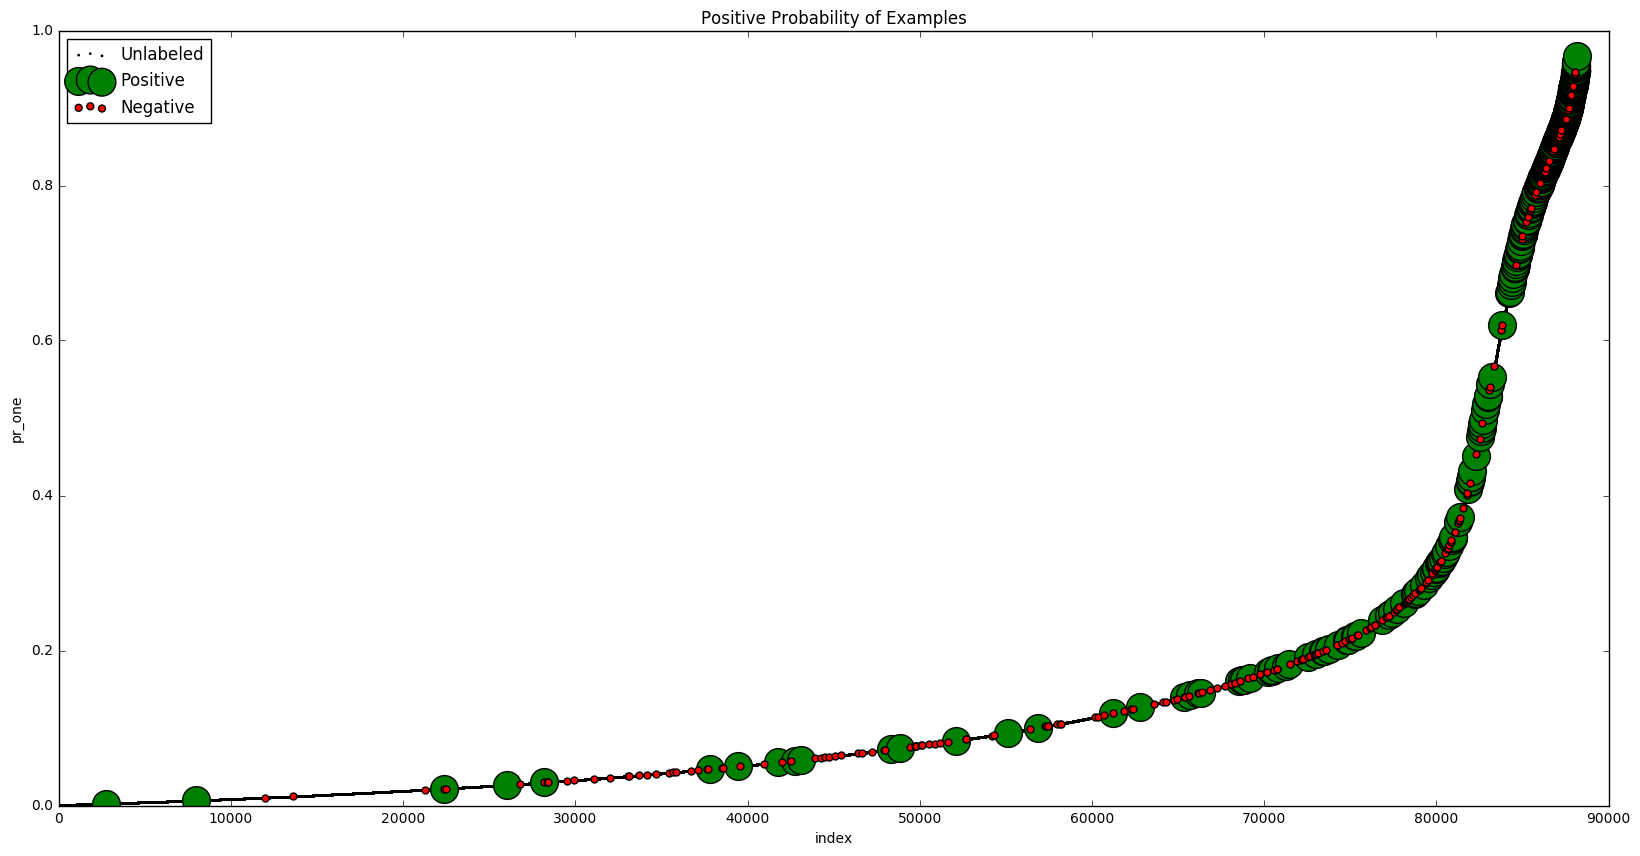

In [14]:
deep.generate_probability_plot()

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    9.4s finished


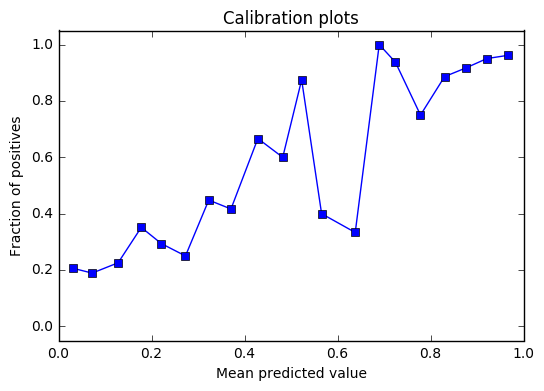

In [29]:
deep.generate_calibration_plot()

In [12]:
# Note if first time running this you will need to generate "explanations" before this step
# using ModelDeepDive.generate_explanations(...)
deep.import_explanations_from_file('res/explanations1000.pkl')

Loaded 1000 explanations from res/explanations1000.pkl
There are now 1000 explanations available


In [13]:
rules_df, features_df = deep.analyze_features()
rules_df_0, features_df_0 = deep.analyze_subgroup(0)
rules_df_5, features_df_5 = deep.analyze_subgroup(5)
rules_df_9, features_df_9 = deep.analyze_subgroup(9)

In [14]:
rules_df.iloc[:20, :]

,N,abs_weight_sum,weight_sum,importance,importance_normal,avg_weight
DIAG_FLAG5_Sum <= 0.00,863,428.513080,-428.513080,20.700557,0.075292,-0.496539
DIAG_FLAG4_Sum > 0.00,526,238.772307,238.772307,15.452259,0.056203,0.453940
DIAG_FLAG4_Sum <= 0.00,474,214.551574,-214.551574,14.647579,0.053276,-0.452640
DIAG_FLAG5_Sum > 0.00,137,67.535312,67.535312,8.217987,0.029890,0.492958
DIAG_FLAG6_Sum <= 0.00,885,58.004293,-58.004293,7.616055,0.027701,-0.065542
ndc_cat45_Sum <= 0.00,947,55.518542,-55.518542,7.451077,0.027101,-0.058626
ndc_cat58_Sum > 1.00,430,31.317450,31.317450,5.596200,0.020354,0.072831
ndc_cat58_Sum <= 0.00,453,25.188275,-25.188275,5.018792,0.018254,-0.055603
DIAG_FLAG41_Sum <= 0.00,855,22.079123,-22.079123,4.698843,0.017091,-0.025824
DIAG_FLAG60_Sum <= 0.00,788,10.713534,-10.713534,3.273154,0.011905,-0.013596


In [12]:
rules_df_0.iloc[:20, :]

,N,abs_weight_sum,weight_sum,importance,importance_normal,avg_weight
DIAG_FLAG5_Sum <= 0.00,86,42.637586,-42.637586,6.529746,0.093910,-0.495786
DIAG_FLAG4_Sum <= 0.00,86,38.869474,-38.869474,6.234539,0.089665,-0.451971
DIAG_FLAG6_Sum <= 0.00,84,5.456684,-5.456684,2.335955,0.033596,-0.064961
ndc_cat45_Sum <= 0.00,83,4.751781,-4.751781,2.179858,0.031351,-0.057250
ndc_cat58_Sum <= 0.00,73,4.072371,-4.072371,2.018012,0.029023,-0.055786
DIAG_FLAG41_Sum <= 0.00,77,2.012663,-2.012663,1.418684,0.020403,-0.026138
CPT_FLAG9_Sum <= 0.00,80,1.280985,-1.280985,1.131806,0.016278,-0.016012
DIAG_FLAG60_Sum <= 0.00,81,1.124994,-1.124994,1.060657,0.015254,-0.013889
DIAG_FLAG85_Sum <= 0.00,75,0.982159,-0.982159,0.991040,0.014253,-0.013095
ndc_cat15_Sum <= 0.00,78,0.918949,-0.918949,0.958618,0.013787,-0.011781


In [13]:
rules_df_5.iloc[:20, :]

,N,abs_weight_sum,weight_sum,importance,importance_normal,avg_weight
DIAG_FLAG5_Sum <= 0.00,99,49.165343,-49.165343,7.011800,0.089334,-0.496620
DIAG_FLAG4_Sum > 0.00,95,43.230997,43.230997,6.575028,0.083769,0.455063
DIAG_FLAG6_Sum <= 0.00,95,6.212772,-6.212772,2.492543,0.031756,-0.065398
ndc_cat45_Sum <= 0.00,94,5.475492,-5.475492,2.339977,0.029812,-0.058250
ndc_cat58_Sum <= 0.00,54,2.993206,-2.993206,1.730089,0.022042,-0.055430
DIAG_FLAG41_Sum <= 0.00,89,2.282682,-2.282682,1.510855,0.019249,-0.025648
DIAG_FLAG4_Sum <= 0.00,4,1.827696,-1.827696,1.351923,0.017224,-0.456924
ndc_cat58_Sum > 1.00,21,1.517864,1.517864,1.232016,0.015697,0.072279
CPT_FLAG9_Sum > 0.00,79,1.227550,1.227550,1.107949,0.014116,0.015539
DIAG_FLAG60_Sum <= 0.00,85,1.170944,-1.170944,1.082102,0.013787,-0.013776


In [14]:
rules_df_9.iloc[:20, :]

,N,abs_weight_sum,weight_sum,importance,importance_normal,avg_weight
DIAG_FLAG4_Sum > 0.00,65,29.665099,29.665099,5.446568,0.070260,0.456386
DIAG_FLAG5_Sum > 0.00,56,27.584704,27.584704,5.252114,0.067751,0.492584
DIAG_FLAG5_Sum <= 0.00,32,15.999438,-15.999438,3.999930,0.051598,-0.499982
DIAG_FLAG4_Sum <= 0.00,23,10.482055,-10.482055,3.237600,0.041765,-0.455742
DIAG_FLAG6_Sum <= 0.00,84,5.550375,-5.550375,2.355923,0.030391,-0.066076
ndc_cat45_Sum <= 0.00,85,5.106742,-5.106742,2.259810,0.029151,-0.060079
ndc_cat58_Sum > 1.00,61,4.455187,4.455187,2.110731,0.027228,0.073036
DIAG_FLAG41_Sum <= 0.00,79,2.066086,-2.066086,1.437389,0.018542,-0.026153
ndc_cat58_Sum <= 0.00,25,1.371228,-1.371228,1.170994,0.015106,-0.054849
ndc_cat87_Sum > 2.00,39,1.198727,1.198727,1.094864,0.014124,0.030737


In [16]:
rules_df_9.sort_values('avg_weight', ascending=False).iloc[:10,:]

,N,abs_weight_sum,weight_sum,importance,importance_normal,avg_weight
DIAG_FLAG5_Sum > 0.00,56,27.584704,27.584704,5.252114,0.067751,0.492584
DIAG_FLAG4_Sum > 0.00,65,29.665099,29.665099,5.446568,0.070260,0.456386
ndc_cat58_Sum > 1.00,61,4.455187,4.455187,2.110731,0.027228,0.073036
DIAG_FLAG6_Sum > 0.00,4,0.257695,0.257695,0.507637,0.006548,0.064424
ndc_cat87_Sum > 2.00,39,1.198727,1.198727,1.094864,0.014124,0.030737
DIAG_FLAG41_Sum > 0.00,9,0.233896,0.233896,0.483628,0.006239,0.025988
age > 56.00,29,0.713595,0.713595,0.844745,0.010897,0.024607
CPT_FLAG1_Sum <= 0.00,1,0.021909,0.021909,0.148017,0.001909,0.021909
ndc_cat63_Sum > 0.00,1,0.018195,0.018195,0.134888,0.001740,0.018195
DIAG_FLAG80_Sum > 0.00,8,0.131787,0.131787,0.363025,0.004683,0.016473
